<a href="https://colab.research.google.com/github/nkasmanoff/DeepRL/blob/master/Load_CarRacing_In_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is used to train a DQN on the CarRacing Open AI gym environment, using a GPU, but most importantly, is able to load this environment!

# CoLab Preambles

Most of the requirements of python packages are already fulfilled on CoLab. To run Gym, you have to install prerequisites like xvbf,opengl & other python-dev packages using the following codes.

[](To be done next time: )
[](https://becominghuman.ai/lets-build-an-atari-ai-part-1-dqn-df57e8ff3b26)

In [1]:
#!pip install gym
#!apt-get install python-opengl -y
#!apt install xvfb -y

In [2]:
#!pip install gym[atari]

For rendering environment, you can use pyvirtualdisplay. So fulfill that 

In [3]:
#!pip install pyvirtualdisplay
#!pip install piglet

To activate virtual display we need to run a script once for training an agent, as follows:

In [6]:
#from pyvirtualdisplay import Display
#display = Display(visible=0, size=(1400, 900))
#display.start()

In [7]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [8]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
#import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [4]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [9]:
from gym import envs
#print(envs.registry.all())

## Add your own environments


In [10]:
#!pip install gym[atari]

## Box2d

Box2d is a 2D physics engine. You can install it via  and then get started as follow:

In [11]:
#!pip install gym[box2d]

/Users/noahkasmanoff/anaconda3/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Track generation: 1008..1266 -> 258-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 985..1242 -> 257-tiles track


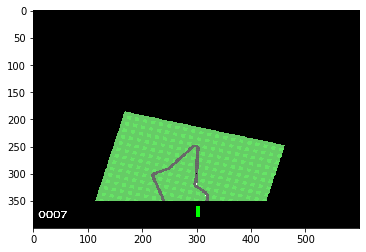

In [12]:
# Box2d Environment
env = gym.make('CarRacing-v0')
env.reset()
#plt.imshow(env.render('rgb_array'))
#env.render()

# Environment successfully loaded in. 

# Next up, instantiate DQN Modules

In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import gym

%matplotlib inline

In [73]:
def test_preprocess(state):
    """
    Same as in HW1. Use these preprocessing functions to 
    """
    state = state[:-12:,6:-6]
    state = rgb2gray(state)
    state = state / 255
    state = state  * 2 - 1
    

    return state


def grab_test_history(state,state_history,history_length): 
    if len(state_history) >= history_length:
        state_input = np.array(state_history[-history_length:])

    
    else:
        remainder = history_length - len(state_history)
        padding = np.zeros(shape = (remainder,84,84))
        state_input = np.array(state_history[-history_length:])
        state_input = np.concatenate((padding,state_input))
        
    state_input = torch.from_numpy(state_input).resize(1,history_length,84,84).float()
    return state_input    
            


In [77]:

class DeepQNetwork(nn.Module):
    """
    Deep Q Network module. 
    
    It instantiates the class optimizer, device, and all the layers used. 
    
    Same architecture as the one used in HW1, since that seemed to learn things!
    
    
    """
    def __init__(self,lr,in_ch=3,action_dim=3,ch=2):
        super(DeepQNetwork,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_ch,out_channels=ch*8,kernel_size=7)
        self.conv2 = nn.Conv2d(in_channels=ch*8,out_channels=ch*16,kernel_size=3,stride=2)
        self.conv3 = nn.Conv2d(in_channels=ch*16,out_channels=ch*16,kernel_size=7)
        self.conv4 = nn.Conv2d(in_channels=ch*16,out_channels=ch*32,kernel_size=3,stride=2)
        self.conv5 = nn.Conv2d(in_channels=ch*32,out_channels=ch*32,kernel_size=7)
        self.conv6 = nn.Conv2d(in_channels=ch*32,out_channels=ch*64,kernel_size=3,stride=2)
        self.fc1 = nn.Linear(64 * ch * 4 * 4,256)
        self.fc2 = nn.Linear(256,action_dim)
        
        self.ch = ch
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

        
    def forward(self, x):
        
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))

        x = x.view(-1, 64 * self.ch * 4 * 4)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
     
        x[:,0] = torch.tanh(x[:,0])
        x[:,1] = torch.sigmoid(x[:,1])
        x[:,2] = torch.sigmoid(x[:,2])


        return x    
    

class Agent(object):
    """
    
    Agent class, holding the RL hyper-params not necessarily contained in the DQN. 
    
    TODO: Polyak Averaging
    
    """
    def __init__(self, gamma, epsilon, alpha,history_length, batch_size,ch=4, n_actions=3,
                 max_mem_size=100000, eps_end=0.01, eps_dec=0.996,target_update=100):
        self.GAMMA = gamma
        self.EPSILON = epsilon
        self.EPS_MIN = eps_end
        self.EPS_DEC = eps_dec
        self.alpha = alpha
        self.n_actions = n_actions
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.history_length = history_length
        self.ch = ch

        self.Q_eval = DeepQNetwork(lr = self.alpha,in_ch=self.history_length,action_dim=self.n_actions,ch=self.ch)
                                     
        self.Q_target = DeepQNetwork(lr = self.alpha,in_ch=self.history_length,action_dim=self.n_actions,ch=self.ch)
                                     
        input_dims=[history_length,84,84]
        self.state_memory = np.zeros((self.mem_size, *input_dims))
        self.new_state_memory = np.zeros((self.mem_size, *input_dims))
        self.action_memory = np.zeros((self.mem_size, self.n_actions),
                                      dtype=np.uint8)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.uint8)
        self.target_counter = 0 #update target counter 
        self.target_update = target_update
        
    def storeTransition(self, state, action, reward, state_, terminal):
        """
        
        stores s a s' r and done flag for td updates done with the target network. 
        
        """
        
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        actions = np.zeros(self.n_actions)
        #actions[action] = 1.0 #one hot encodes the action
        self.action_memory[index] = actions
        self.reward_memory[index] = reward
        self.new_state_memory[index] = state_
        self.terminal_memory[index] = 1 - terminal
        self.mem_cntr += 1 #update total size so we know when to update it. 

    def chooseAction(self, observation):
        #select an action according to epsilon greedy strategy. 
        rand = np.random.random()
        action = self.Q_eval.forward(observation)
        if rand > self.EPSILON:
            action = action.numpy() #
        else:
            action = env.action_space.sample()
        return action

    def learn(self):
        if self.mem_cntr > self.batch_size: 
            #once you have accumulated enough transitions, begin training. 
            self.Q_eval.optimizer.zero_grad()

            max_mem = self.mem_cntr if self.mem_cntr < self.mem_size \
                                    else self.mem_size

            
            batch = np.random.choice(max_mem, self.batch_size)
            
            state_batch = self.state_memory[batch]
            action_batch = self.action_memory[batch]
            action_values = np.array(self.n_actions, dtype=np.int32)
            action_indices = np.dot(action_batch, action_values)
            reward_batch = self.reward_memory[batch]
            new_state_batch = self.new_state_memory[batch]
            terminal_batch = self.terminal_memory[batch]

            reward_batch = torch.Tensor(reward_batch).to(self.Q_eval.device)
            terminal_batch = torch.Tensor(terminal_batch).to(self.Q_eval.device)

            q_eval = self.Q_eval.forward(torch.from_numpy(state_batch).float()).to(self.Q_eval.device)
            #q_target = self.Q_eval.forward(state_batch).to(self.Q_eval.device)
            q_target = self.Q_target.forward(torch.from_numpy(state_batch).float()).to(self.Q_eval.device)
            q_next = self.Q_eval.forward(torch.from_numpy(new_state_batch).float()).to(self.Q_eval.device)

            batch_index = np.arange(self.batch_size, dtype=np.int32)
            q_target[batch_index, action_indices] = reward_batch + \
                                self.GAMMA*torch.max(q_next, dim=1)[0]*terminal_batch

            self.EPSILON = self.EPSILON*self.EPS_DEC if self.EPSILON > \
                           self.EPS_MIN else self.EPS_MIN

            loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
            loss.backward()
            self.Q_eval.optimizer.step()
            self.target_counter += 1
            
            if self.target_counter >= self.target_update:
                #update weights, reset counter
                self.Q_target.load_state_dict(self.Q_eval.state_dict())
                self.target_counter = 0

In [78]:

def rgb2gray(rgb):
    """ 
    this method converts rgb images to grayscale.
    """
    gray = np.dot(rgb[...,:3], [0.2125, 0.7154, 0.0721])
    return gray.astype('float32') 
def test_preprocess(state):
    state = state[:-12:,6:-6]
    state = rgb2gray(state)
    state = state / 255
    state = state  * 2 - 1
    

    return state


def grab_test_history(state,state_history,history_length): 
    if len(state_history) >= history_length:
        state_input = np.array(state_history[-history_length:])

    
    else:
        remainder = history_length - len(state_history)
        padding = np.zeros(shape = (remainder,84,84))
        state_input = np.array(state_history[-history_length:])
        state_input = np.concatenate((padding,state_input))
        
    state_input = torch.from_numpy(state_input).resize(1,history_length,84,84).float()
    return state_input    
            



In [79]:
# Now the main!


env = gym.make('CarRacing-v0')
agent = Agent(gamma=.9, epsilon=.999, alpha=.001,history_length=3, batch_size=16,ch=4, n_actions=3,
                 max_mem_size=100000, eps_end=0.01, eps_dec=0.996,target_update=100)
scores = []
eps_history = []
n_games = 500
score = 0
for i in range(n_games):
    if i % 10 and i > 0:
        avg_score = np.mean(scores[max(0,i-10):(i+1)])
        print("Episode i", i, 'average score', avg_score)
        
        
    score = 0 
    eps_history.append(agent.EPSILON)
    state_history = []
    state = env.reset()
    state = test_preprocess(state)
    state_history.append(state)
    state_input = grab_test_history(state,state_history,history_length=3)

    done = False
    while not done:
        #env.render()
        action = agent.chooseAction(state_input)
        state,reward,done, _ = env.step(action)

        state = test_preprocess(state)

        state_history.append(state)
        old_state_input = state_input
        
        state_input = grab_test_history(state,state_history,history_length=3)
        
        agent.storeTransition(old_state_input,action,reward, state_input, done)
        agent.learn()
        
        #observation = observation_
        score += reward

    scores.append(score)


Track generation: 1095..1379 -> 284-tiles track


IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [16], [16, 3]

In [ ]:
%debug

> <ipython-input-77-7bb3be4a6496>(144)learn()
    142             batch_index = np.arange(self.batch_size, dtype=np.int32)
    143             q_target[batch_index, action_indices] = reward_batch + \
--> 144                                 self.GAMMA*torch.max(q_next, dim=1)[0]*terminal_batch
    145 
    146             self.EPSILON = self.EPSILON*self.EPS_DEC if self.EPSILON > \



ipdb>  q_next


tensor([[-0.0345,  0.4978,  0.5057],
        [-0.0343,  0.4978,  0.5057],
        [-0.0345,  0.4978,  0.5057],
        [-0.0345,  0.4978,  0.5057],
        [-0.0345,  0.4978,  0.5057],
        [-0.0345,  0.4978,  0.5057],
        [-0.0345,  0.4978,  0.5057],
        [-0.0345,  0.4978,  0.5057],
        [-0.0345,  0.4978,  0.5057],
        [-0.0346,  0.4978,  0.5059],
        [-0.0345,  0.4978,  0.5056],
        [-0.0345,  0.4978,  0.5057],
        [-0.0345,  0.4978,  0.5057],
        [-0.0345,  0.4978,  0.5057],
        [-0.0345,  0.4978,  0.5059],
        [-0.0345,  0.4978,  0.5057]], grad_fn=<CopySlices>)


In [ ]:
#Extra credit: Use the polyak average as the weight update rule, as opposed to a variably lagged target. 

def polyak_update(polyak_factor, target_network, network):
    for target_param, param in zip(target_network.parameters(), network.parameters()):
        target_param.data.copy_(polyak_factor*param.data + target_param.data*(1.0 - polyak_factor))